In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pathlib import Path

# PyStar Core Imports
from pystar.infrastructure import load_config
from pystar.io import ImageLoader
from pystar.preprocessing import DataSanitizer
from pystar.registration import RegistrationEngine
from pystar.spot_finding import SpotFinder
from pystar.mining import SignalMiner
from pystar.decoding import Decoder
from pystar.visualization import overlay_rgb, inspect_spots_interactive, plot_spot_traces, plot_channel_correlation
from pystar.visualization import SpotInspector

# Load Config
config_path = "experiment_config.yaml"
try:
    cfg = load_config(config_path)
    print(" Config loaded. We are ready.")
except Exception as e:
    print(f" Config failure: {e}")
    raise

# Initialize Engines
loader = ImageLoader(cfg)
reg_engine = RegistrationEngine(cfg)
spot_finder = SpotFinder(cfg)
miner = SignalMiner(cfg)

# Define our target
FOV_ID = 1
print(f" Targeting Position: {FOV_ID}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
 Config loaded. We are ready.
 Targeting Position: 1


In [ ]:
# 1. 运行净化

sanitizer = DataSanitizer(cfg)
sanitizer.sanitize_fov(1)

# 2. 直方图检查 (Visual Proof)
import tifffile
import matplotlib.pyplot as plt
import numpy as np

# 读取 Round 1 的 Raw 和 Clean (Ch0 vs Ch1)
raw_c0 = tifffile.imread(loader._get_path(1, 1, 0))[15] # Z=15
clean_c0 = tifffile.imread(sanitizer.clean_dir / "clean_fov_1_round_1_ch_0.tif")[15]

raw_c1 = tifffile.imread(loader._get_path(1, 1, 2))[15]
clean_c1 = tifffile.imread(sanitizer.clean_dir / "clean_fov_1_round_1_ch_1.tif")[15]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Raw 对比
axes[0, 0].imshow(raw_c0, cmap='gray', vmin=0, vmax=np.percentile(raw_c0, 99))
axes[0, 0].set_title("Raw CH0 (Z=15)")
axes[0, 1].imshow(raw_c1, cmap='gray', vmin=0, vmax=np.percentile(raw_c0, 99)) # 用 C0 的 scale 看 C1
axes[0, 1].set_title("Raw CH1 (Same Scale as CH0)")

# Clean 对比
axes[1, 0].imshow(clean_c0, cmap='gray', vmin=0, vmax=100) # 假设100是清洗后的信号强度
axes[1, 0].set_title("Clean CH0 (Histogram Matching)")
axes[1, 1].imshow(clean_c1, cmap='gray', vmin=0, vmax=100)
axes[1, 1].set_title("Clean CH1 (Histogram Matching)")

plt.show()

# 3. 统计检查 (Histogram)
plt.figure(figsize=(10, 5))
plt.hist(clean_c0.flatten(), bins=100, range=(1, 200), alpha=0.5, label='Clean CH0', log=True)
plt.hist(clean_c1.flatten(), bins=100, range=(1, 200), alpha=0.5, label='Clean CH1', log=True)
plt.legend()
plt.title("Histogram of CLEAN Signal (Background 0 excluded)")
plt.show()

[==================== Sanitizing FOV 1 ====================]
 -> Pipeline Split: 4 Calibration steps + 1 Extraction steps
 -> Processing Round 1...
 -> Processing Round 2...
 -> Processing Round 3...
 -> Processing Round 4...


[==================== Sanitizing FOV 1 ====================]
 [Phase 1] Processing Reference Round 1...
 [Phase 2] Processing Round 2...
 [Phase 2] Processing Round 3...
 [Phase 2] Processing Round 4...
 [Phase 2] Processing Round 5...
 [Phase 2] Processing Round 6...
 [Phase 2] Processing Round 7...
 [Phase 2] Processing Round 8...
 [Phase 2] Processing Round 9...
 [Phase 2] Processing Round 10...
 [Phase 2] Processing Round 11...
Done.


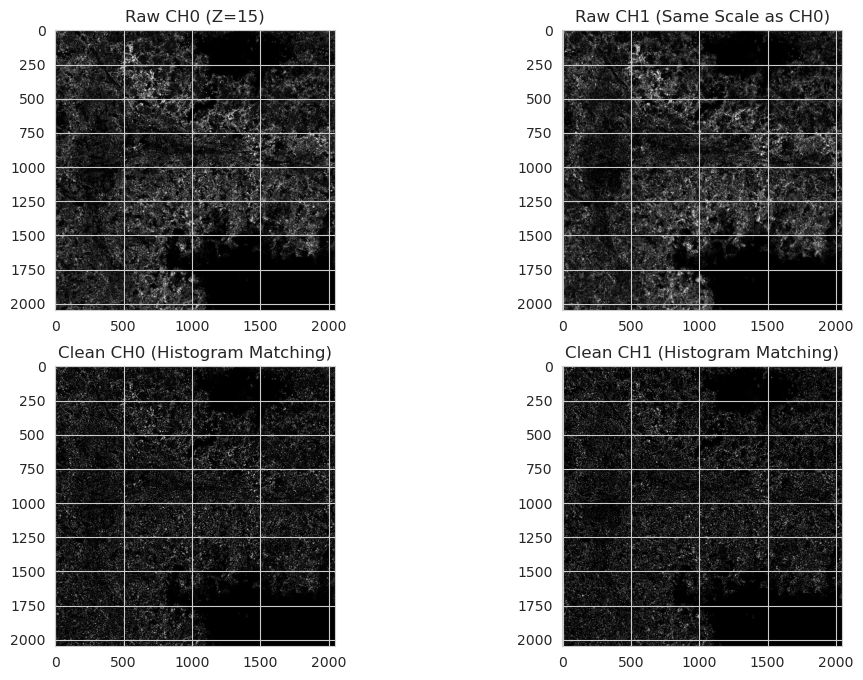

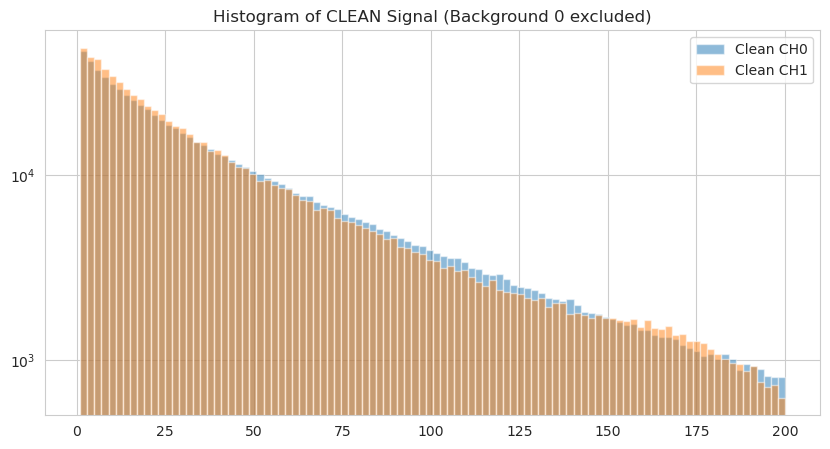

In [18]:
# 1. 运行净化

sanitizer = DataSanitizer(cfg)
sanitizer.sanitize_fov(1)

# 2. 直方图检查 (Visual Proof)
import tifffile
import matplotlib.pyplot as plt
import numpy as np

# 读取 Round 1 的 Raw 和 Clean (Ch0 vs Ch1)
raw_c0 = tifffile.imread(loader._get_path(1, 1, 0))[15] # Z=15
clean_c0 = tifffile.imread(sanitizer.clean_dir / "clean_fov_1_round_1_ch_0.tif")[15]

raw_c1 = tifffile.imread(loader._get_path(1, 1, 2))[15]
clean_c1 = tifffile.imread(sanitizer.clean_dir / "clean_fov_1_round_1_ch_1.tif")[15]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Raw 对比
axes[0, 0].imshow(raw_c0, cmap='gray', vmin=0, vmax=np.percentile(raw_c0, 99))
axes[0, 0].set_title("Raw CH0 (Z=15)")
axes[0, 1].imshow(raw_c1, cmap='gray', vmin=0, vmax=np.percentile(raw_c0, 99)) # 用 C0 的 scale 看 C1
axes[0, 1].set_title("Raw CH1 (Same Scale as CH0)")

# Clean 对比
axes[1, 0].imshow(clean_c0, cmap='gray', vmin=0, vmax=100) # 假设100是清洗后的信号强度
axes[1, 0].set_title("Clean CH0 (Histogram Matching)")
axes[1, 1].imshow(clean_c1, cmap='gray', vmin=0, vmax=100)
axes[1, 1].set_title("Clean CH1 (Histogram Matching)")

plt.show()

# 3. 统计检查 (Histogram)
plt.figure(figsize=(10, 5))
plt.hist(clean_c0.flatten(), bins=100, range=(1, 200), alpha=0.5, label='Clean CH0', log=True)
plt.hist(clean_c1.flatten(), bins=100, range=(1, 200), alpha=0.5, label='Clean CH1', log=True)
plt.legend()
plt.title("Histogram of CLEAN Signal (Background 0 excluded)")
plt.show()

 Launching Registration Engine for FOV 1...
DEBUG: Loading FOV 1 structure... Done.

  [Registration] FOV 1 | Reference: Round 1



  >> Round 2
     Global Shift (3D): [ 0.1  3.1 16.6], Corr (Est): 0.2589
     After Global (Clean MIP): Corr = 0.7084
  [Demons 3D] Starting registration (pyramid levels: 5)...
  [Demons 3D] Finished. Mean displacement: 0.23 px
  After Local 3D: Corr = 0.7740 (Δ = +0.0656)
   [QC] Saved visual report: alignment_qc_fov1_round2.jpg

  >> Round 3
     Global Shift (3D): [-0.7  0.3 15.7], Corr (Est): 0.2510
     After Global (Clean MIP): Corr = 0.7061
  [Demons 3D] Starting registration (pyramid levels: 5)...
  [Demons 3D] Finished. Mean displacement: 0.23 px
  After Local 3D: Corr = 0.7691 (Δ = +0.0630)
   [QC] Saved visual report: alignment_qc_fov1_round3.jpg

  >> Round 4
     Global Shift (3D): [-0.2 -8.   4.6], Corr (Est): 0.2007
     After Global (Clean MIP): Corr = 0.6166
  [Demons 3D] Starting registration (pyramid levels: 5)...
  [Demons 3D] Finished. Mean displacement: 0.22 px
  After Local 3D: Corr = 0.7030 (Δ = +0.0863)
   [QC] Saved visual report: alignment_qc_fov1_round4.jp

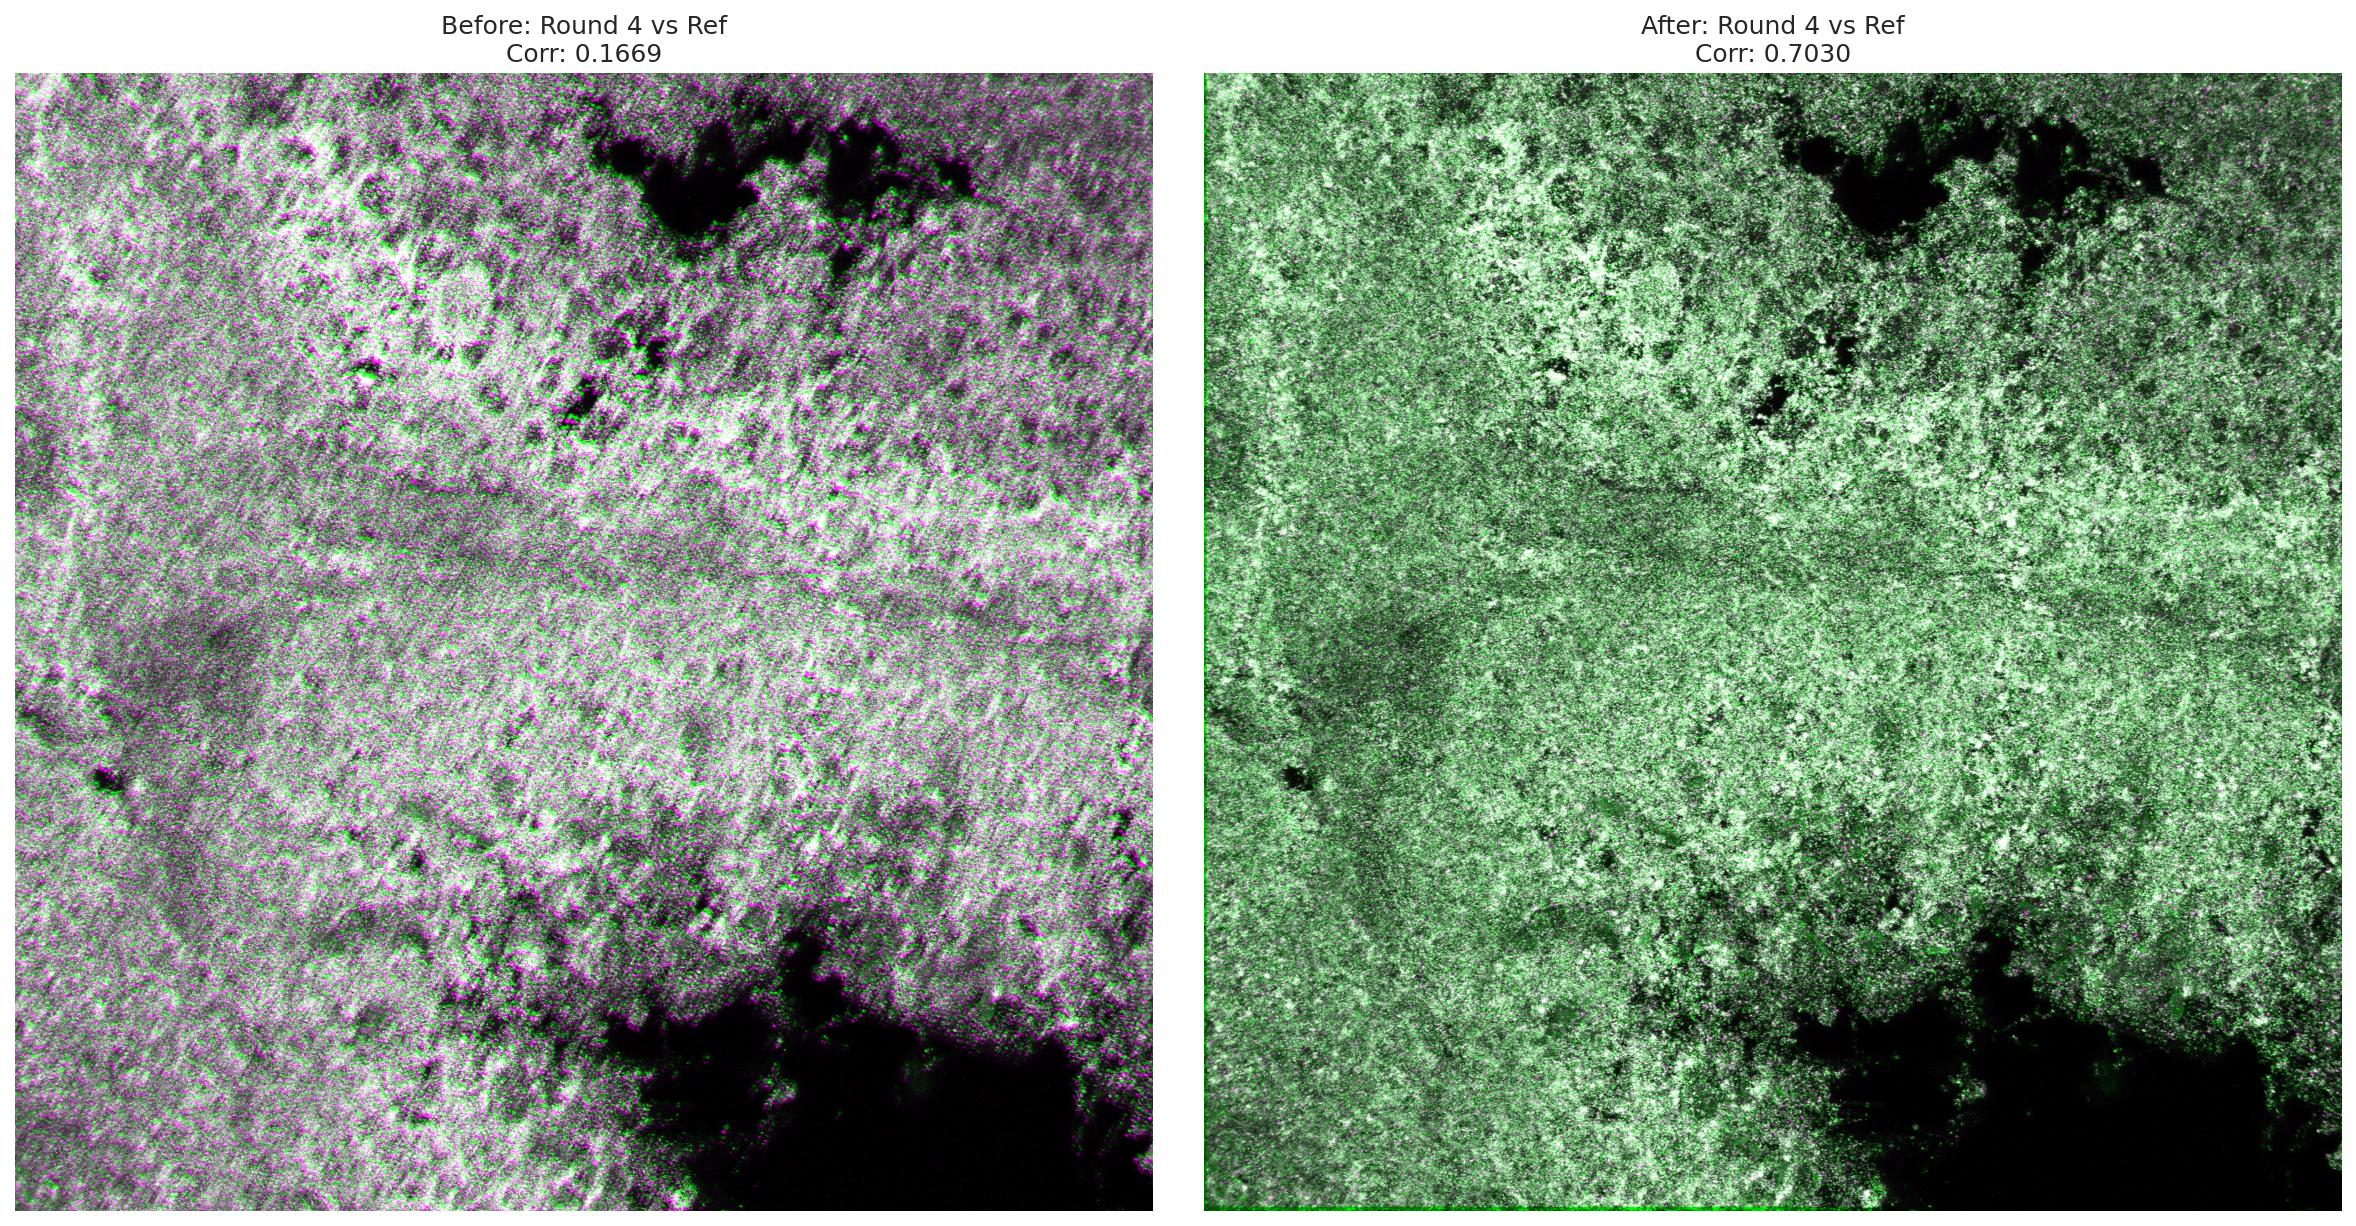

In [19]:
# 运行配准流程
# 这会将变换参数写入 disk，并保存 Clean Reference Image
print(f" Launching Registration Engine for FOV {FOV_ID}...")

# 这一行代码封装了所有的复杂性：Global FFT -> Local B-Spline -> Save
transforms = reg_engine.register_fov(loader.load_fov(FOV_ID), FOV_ID)

# --- Immediate QC (Look at result immediately) ---
# 让我们看看 drift 最严重的 Round (通常是最后一轮，或者 R4)
QC_ROUND = 4 
if QC_ROUND in transforms:
    t_data = transforms[QC_ROUND]
    print(f"\n QC Report for Round {QC_ROUND}:")
    print(f"   Global Shift: {t_data['global_shift_3d']}")
    print(f"   Correlation (Global Only): {t_data.get('global_corr', 0):.4f}")
    print(f"   Correlation (Final):       {t_data.get('final_corr', 0):.4f}")
    
    # 显示保存到硬盘上的 QC 图片 (如果有的话)
    qc_path = Path(cfg.pipeline.qc.output_dir) / f"alignment_qc_fov{FOV_ID}_round{QC_ROUND}.jpg"
    if qc_path.exists():
        from IPython.display import Image, display
        print("   Displaying generated QC Report:")
        display(Image(filename=qc_path))
    else:
        print(" QC Image not found on disk.")

 Launching Spot Finder for FOV 1...
 [SpotFinding] Mining FOV 1 using Clean Data (Ref Round 1)...
 [SpotFinding] Target Channels: [0, 1, 2]
Data type: uint8
Value range: [0.00, 255.00]
Mean: 7.13, Std: 25.94
   > Channel 0: found 2629366 spots
Data type: uint8
Value range: [0.00, 255.00]
Mean: 6.76, Std: 24.62
   > Channel 1: found 2561641 spots
Data type: uint8
Value range: [0.00, 255.00]
Mean: 7.48, Std: 26.69
   > Channel 2: found 2219616 spots
 [SpotFinding] Finished. Total: 7410623 spots. Saved to spots_fov_1.csv
 [QC] Saved spot finding QC to spot_finding_qc_fov_1.png
 Spots Found: 7410623
     z    y     x  intensity  channel  fov            algo
0  0.0  0.0   2.0         52        0    1  peak_local_max
1  0.0  0.0  13.0         54        0    1  peak_local_max
2  0.0  0.0  25.0         48        0    1  peak_local_max
3  0.0  0.0  32.0         17        0    1  peak_local_max
4  0.0  0.0  65.0         48        0    1  peak_local_max
   Displaying generated QC Report:


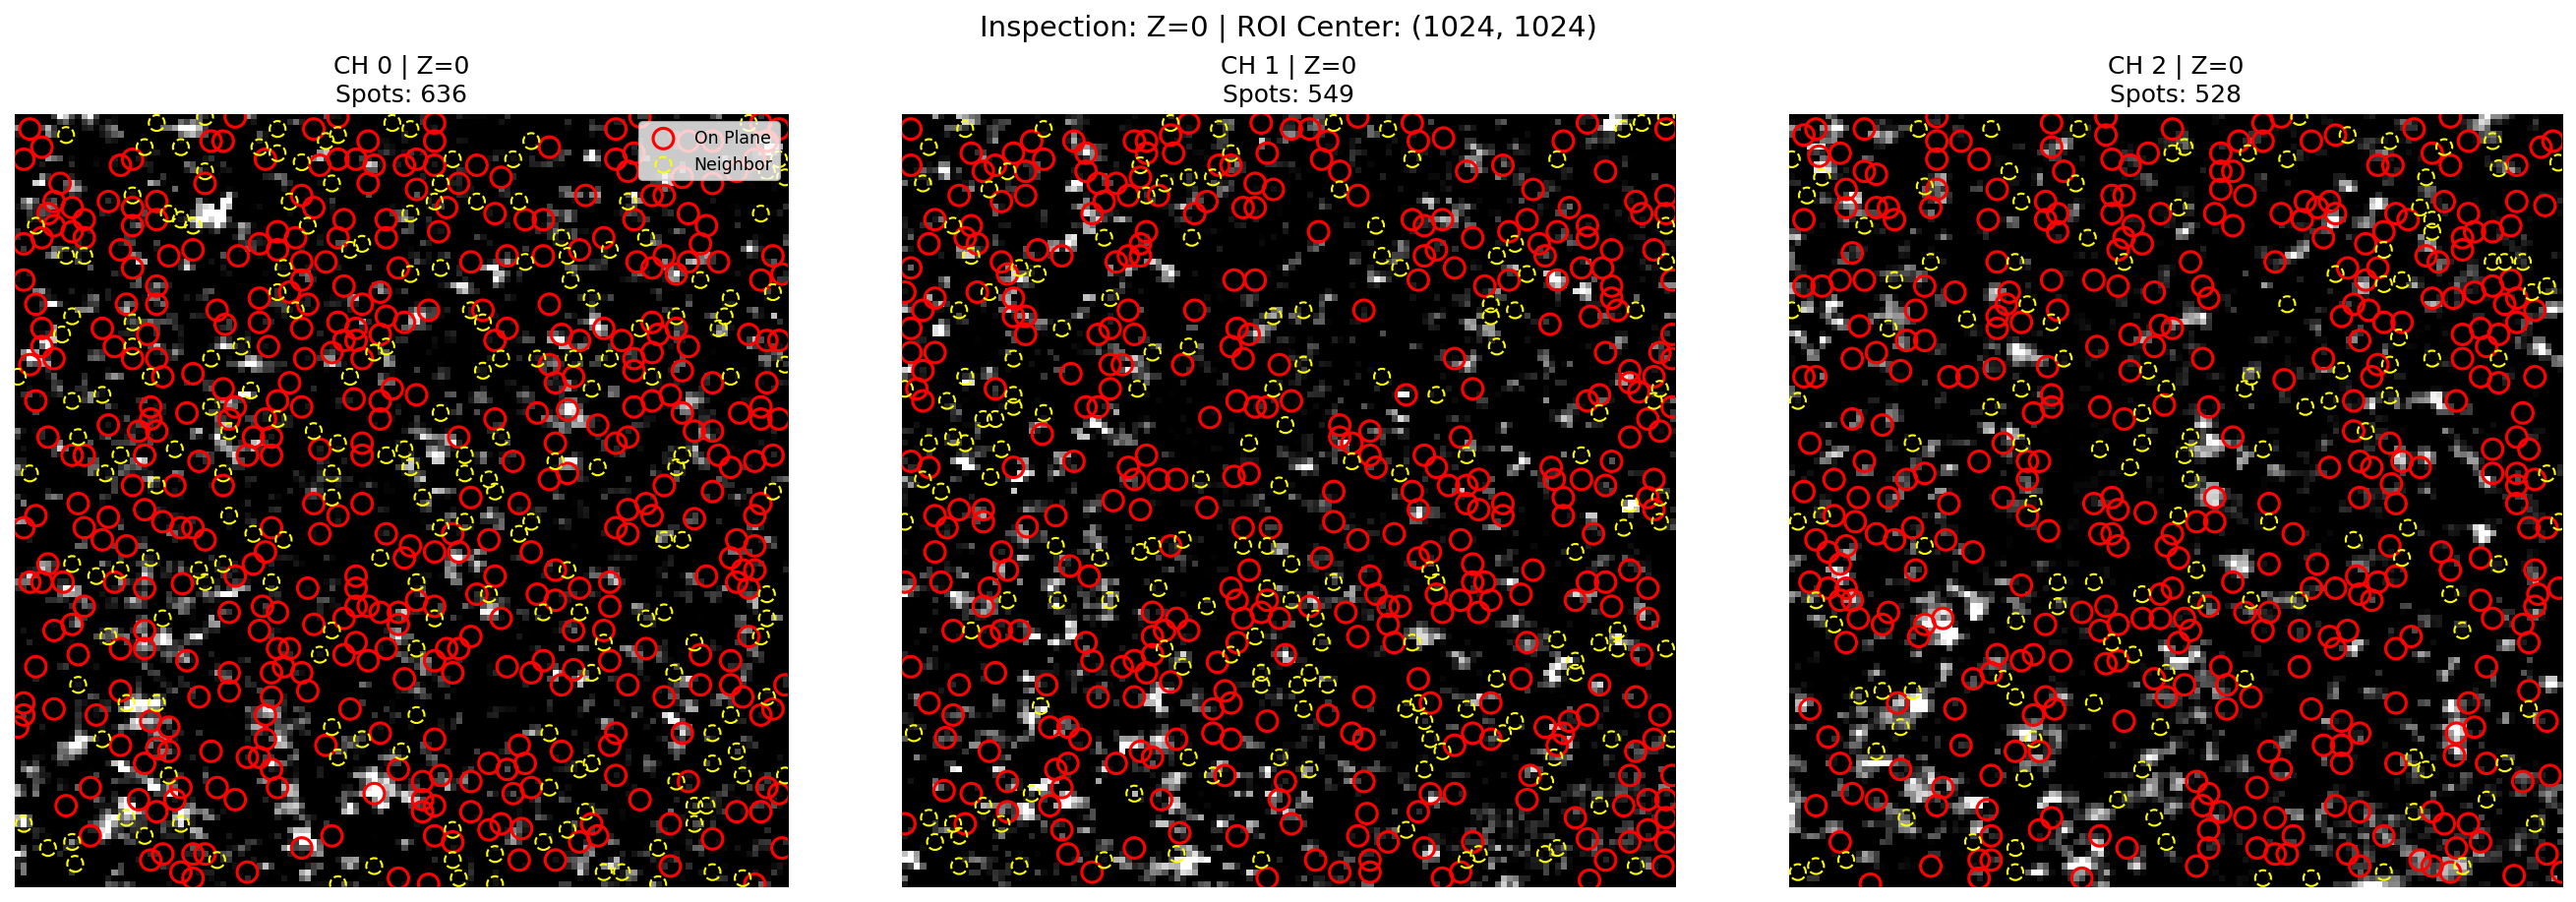

In [5]:
# 运行寻点
# 它会自动读取上一步生成的 ref_clean_fov_1_round_1.tif
print(f" Launching Spot Finder for FOV {FOV_ID}...")

# 这一步生成 spots_fov_1.csv
spots_df = spot_finder.find_spots_in_fov(FOV_ID)

print(f" Spots Found: {len(spots_df)}")
print(spots_df.head())

qc_path = Path(cfg.pipeline.qc.output_dir) / f"spot_finding_qc_fov_{FOV_ID}.png"
if qc_path.exists():
    from IPython.display import Image, display
    print("   Displaying generated QC Report:")
    display(Image(filename=qc_path))
else:
    print(" QC Image not found on disk.")

In [22]:
# 运行提取
# 这是一个 IO 密集型操作
print(f"  Launching Signal Miner for FOV {FOV_ID}...")

# 这一步生成 intensity_matrix_fov_1.npy
miner.mine_fov(FOV_ID)

# 加载回来进行检查
intensity_file = Path(cfg.pipeline.output.directory) / "extraction" / f"intensity_matrix_fov_{FOV_ID}.npy"
intensity_matrix = np.load(intensity_file)

print(f" Matrix Loaded: {intensity_matrix.shape} (Spots, Rounds, Channels)")

  Launching Signal Miner for FOV 1...
[==================== Mining FOV 1 ====================]
 [Miner] Channels to extract: [0, 1, 2]


Extracting Signals: 100%|██████████| 33/33 [03:02<00:00,  5.52s/it]


 [Miner] Saved extraction matrix to intensity_matrix_fov_1.npy | Shape: (7410623, 11, 3)
 [QC] Generating extraction QC plots...
 [QC] Saved spot traces to spot_traces_fov_1.png
 Matrix Loaded: (7410623, 11, 3) (Spots, Rounds, Channels)


 High Intensity Spots Traces:


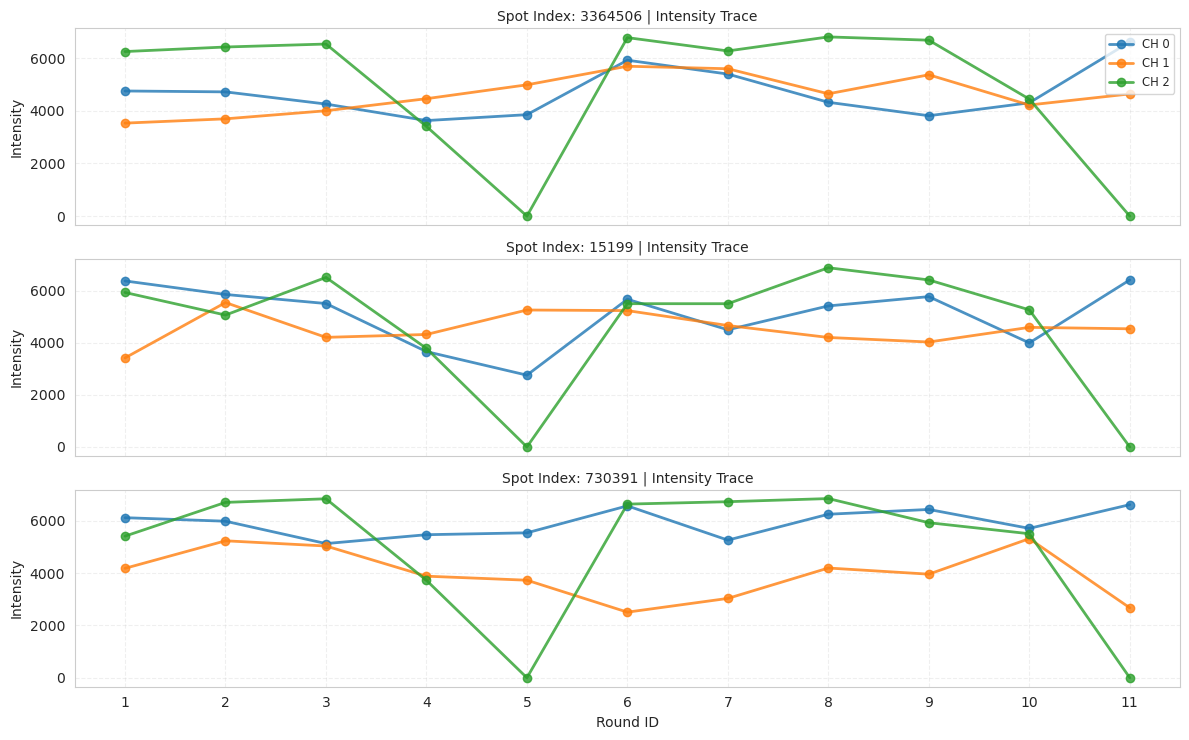

 Random Spots Traces:


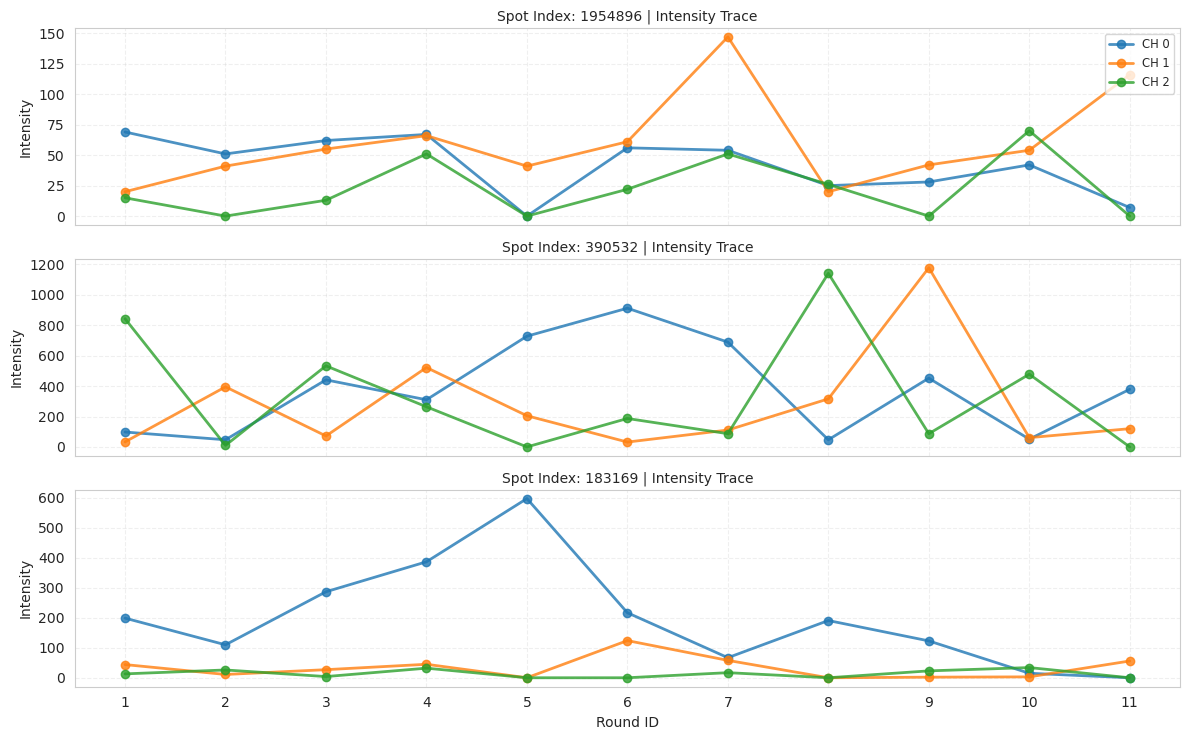

In [23]:
# 准备数据
rounds = sorted(cfg.dataset.round_structure.keys())
all_channels = sorted(cfg.dataset.channel_roles.keys())
channels = [c for c in all_channels if cfg.dataset.channel_roles.get(c) == 'seq']

# 挑亮度最高的几个点 (High Confidence) 和 随机点
total_intensity = intensity_matrix.sum(axis=(1, 2))
top_indices = np.argsort(total_intensity)[-3:] # top 3
random_indices = np.random.choice(len(intensity_matrix), 3, replace=False)

print(" High Intensity Spots Traces:")
plot_spot_traces(intensity_matrix, top_indices, rounds, channels)

print(" Random Spots Traces:")
plot_spot_traces(intensity_matrix, random_indices, rounds, channels)


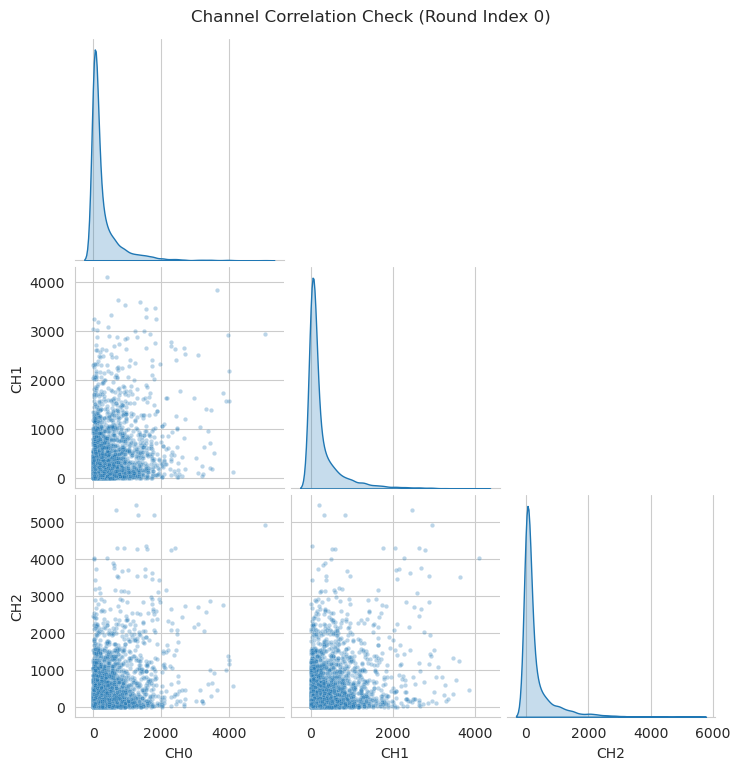

In [24]:
# 简单的通道相关性检查 (For Round 1)
# 取所有点，看 Round 1 的 Channel 0 vs Channel 1
# 如果大部分点要么是 C0 要么是 C1，应该看到 L 型分布
# 检查 Round 1 (Index 0) 
r_idx = 0 
r_id = rounds[r_idx]
ch_labels = [f"CH{c}" for c in channels]

plot_channel_correlation(
    intensity_matrix, 
    round_index=r_idx, 
    channel_labels=ch_labels,
    sample_size=5000
)

In [2]:
try:
    decoder = Decoder(cfg)
    print(" Decoder 初始化成功")
except Exception as e:
    print(f" Decoder 初始化失败: {e}")
    raise

# 偷看一眼编译后的结果
# 我们不仅要看它没报错，还要看它翻译得对不对
print("\n--- Codebook 抽查 (Top 5) ---")
_, df_codebook = decoder._compile_codebook()
print(df_codebook.head())

print(f"\n基因总数: {len(df_codebook)}")
print(f"Barcode 长度 (Round数): {len(df_codebook.iloc[0]['barcode'])}")

# 自动检查：是否有非法字符？
# 我们的 barcode 应该只包含 '0', '1', '2', '3' (如果是4色)
sample_seq = df_codebook.iloc[0]['barcode']
valid_chars = set("0123.") # .代表无法翻译的N碱基
if not set(sample_seq).issubset(valid_chars):
    print(f" 警告：Barcode 中包含奇怪的字符: {set(sample_seq)}，请检查 experiment_config.yaml 的 encoding_map")
else:
    print(" Codebook 格式看起来很健康。")

 [Decoder] Applying Topology: Reverse Sequence
   -> Compiled 6064 barcodes. Debug info saved to compiled_codebook_debug.csv
 Decoder 初始化成功

--- Codebook 抽查 (Top 5) ---
 [Decoder] Applying Topology: Reverse Sequence
   -> Compiled 6064 barcodes. Debug info saved to compiled_codebook_debug.csv
          gene             seq   processed_seq      barcode
0   Aamp_ntRNA  CGAAAATGAAAATA  ATAAAAGTAAAAGC  00111201110
1   Abat_ntRNA  CGAAAATGAAAAGA  AGAAAAGTAAAAGC  00111021110
2  Abca1_ntRNA  CGAAAATGAAATAA  AATAAAGTAAAAGC  00111120110
3  Abcg2_ntRNA  CGAAAATGAAATTA  ATTAAAGTAAAAGC  00111210110
4   Abi2_ntRNA  CGAAAATGAAATGA  AGTAAAGTAAAAGC  00111000110

基因总数: 6064
Barcode 长度 (Round数): 11
 Codebook 格式看起来很健康。


In [3]:
# ==========================================
# 2. 运行解码与统计
# ==========================================
FOV_ID = 1

# 这一步应该很快，纯内存计算
try:
    df_decoded = decoder.decode_fov(FOV_ID)
    print(" 解码完成")
except Exception as e:
    print(f" 解码崩溃: {e}")
    raise

# --- 关键统计 ---
total_spots = len(df_decoded)
mapped_spots = df_decoded[df_decoded['gene'] != 'background']
n_mapped = len(mapped_spots)
mapping_rate = n_mapped / total_spots

print(f"\n{'='*40}")
print(f"RESULT: FOV {FOV_ID}")
print(f"{'='*40}")
print(f"Total Spots   : {total_spots}")
print(f"Mapped Spots  : {n_mapped}")
print(f"Mapping Rate  : {mapping_rate:.2%}") # 这一行决定了成败
print(f"{'='*40}")

# 看看都切出了什么基因
print("\nTop 10 Detected Genes:")
print(mapped_spots['gene'].value_counts().head(10))

[==================== Decoding FOV 1 ====================]
 -> Loaded matrices with shape (7410623, 11, 3). Assuming Seq channels only.
 -> Normalizing intensities...
 -> Calling colors...
   Tie/Invalid detection: 1245608 spots flagged (16.81%)
 -> Filtering by quality score...

 [Filtration Statistics]
   Total spots:        7410623
   Valid (no ties):    6165015 (83.19%)
   Quality pass:       6165015 (83.19%)
   Final kept:         6165015 (83.19%)
   Removed by quality filter:  1245608
 -> Constructing barcodes...
 -> Matching codebook...
 -> Validating end bases pattern...
   Pattern validation removed: 5259388 spots (85.31%)

 [Quality Diagnostics] Average -log(max) per Round:
   Round 1: 0.1510 ✓
   Round 2: 0.1401 ✓
   Round 3: 0.1479 ✓
   Round 4: 0.1592 ✓
   Round 5: 0.0644 ✓
   Round 6: 0.1399 ✓
   Round 7: 0.1373 ✓
   Round 8: 0.1414 ✓
   Round 9: 0.1494 ✓
   Round 10: 0.1512 ✓
   Round 11: 0.0649 ✓

 [Mapping Results]
   Spots after quality filter: 6165015
   Spots after 

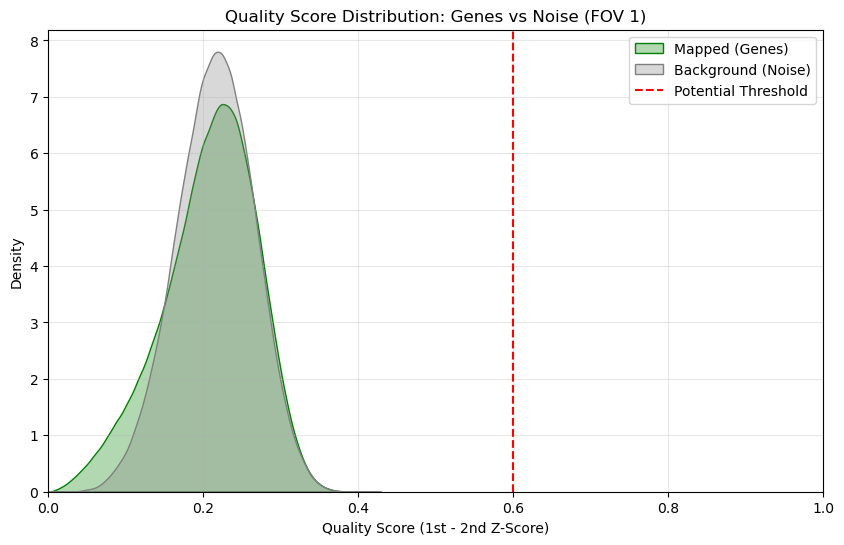

In [11]:
# ==========================================
# 3. 质量评分分布图 (QC)
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# 区分 Mapped 和 Background
sns.kdeplot(data=df_decoded[df_decoded['gene']!='background'], x='quality', 
            label='Mapped (Genes)', fill=True, color='green', alpha=0.3)
sns.kdeplot(data=df_decoded[df_decoded['gene']=='background'], x='quality', 
            label='Background (Noise)', fill=True, color='gray', alpha=0.3)

plt.axvline(x=0.6, color='red', linestyle='--', label='Potential Threshold')
plt.title(f"Quality Score Distribution: Genes vs Noise (FOV {FOV_ID})")
plt.xlabel("Quality Score (1st - 2nd Z-Score)")
plt.xlim(0, 1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 解释：
# 最理想的情况是 Green 集中在右边 (0.8-1.0)，Gray 集中在左边 (0.0-0.4)。
# 如果两个峰完全重叠，说明你的信号提取质量不够，或者串色严重。

In [ ]:
# ==========================================
# 4. 捕捉未匹配的高质量“幽灵”序列
# ==========================================
# 筛选：也就是那些“我很确定我是这个序列，但你在字典里找不到我”的点
high_qual_background = df_decoded[
    (df_decoded['gene'] == 'background') & 
    (df_decoded['quality'] > 0.7)  # 这里的阈值可以动态调整
]

print(f"\n高质量但无法匹配的点数: {len(high_qual_background)}")

if len(high_qual_background) > 0:
    print("\n最常见的'幽灵'序列 (Ghost Barcodes):")
    ghosts = high_qual_background['barcode'].value_counts().head(10)
    print(ghosts)
    
    # 诊断建议
    top_ghost = ghosts.index[0]
    print(f"\n诊断建议: 检查序列 '{top_ghost}'")
    print("1. 它是否只差一位就能变成某个热门基因？(可能是纠错阈值太紧)")
    print("2. 它是否看起来像 '1111' 或 '0000'？(可能是坏点)")
    print("3. 它是否像 '1212' 这种循环？(可能是光学假象)")
else:
    print("没有发现大量高质量的未知序列，很好。")


高质量但无法匹配的点数: 4102644

最常见的'幽灵'序列 (Ghost Barcodes):
00000000002    3464
00000000000    2310
22221222220     980
22220222220     942
00000000001     924
22222222220     919
22211222220     813
22211222200     800
22211222221     786
22211222201     775
Name: barcode, dtype: int64

诊断建议: 检查序列 '00000000002'
1. 它是否只差一位就能变成某个热门基因？(可能是纠错阈值太紧)
2. 它是否看起来像 '1111' 或 '0000'？(可能是坏点)
3. 它是否像 '1212' 这种循环？(可能是光学假象)


各通道平均强度 (R2-R11):
CH0: 152.42
CH1: 113.17
CH2: 138.91


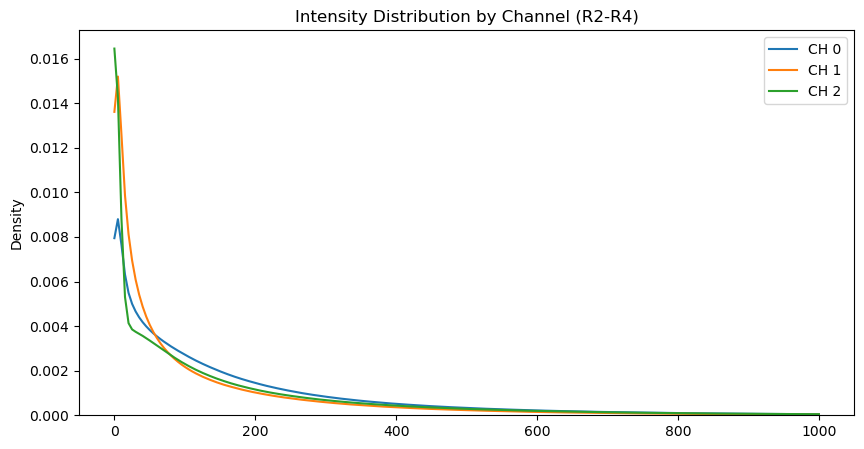

In [ ]:
# ==========================================
# 诊断：为什么总是读出 Channel 0？
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fov_id = 1
# 加载原始矩阵
extracted_path = Path(cfg.pipeline.output.directory) / "extraction" / f"intensity_matrix_fov_{fov_id}.npy"
raw_matrix = np.load(extracted_path)
data_check = raw_matrix[:, 1:12, 0:3] 

# 计算每个通道的平均强度
means = data_check.mean(axis=(0, 1))
print("各通道平均强度 (R2-R11):")
print(f"CH0: {means[0]:.2f}")
print(f"CH1: {means[1]:.2f}")
print(f"CH2: {means[2]:.2f}")
#print(f"CH3: {means[3]:.2f}")

# 画图看分布
plt.figure(figsize=(10, 5))
for c in range(3):
    sns.kdeplot(data_check[:, :, c].flatten(), label=f"CH {c}", clip=(0, 1000)) # clip一下防止长尾
plt.title("Intensity Distribution by Channel (R2-R4)")
plt.legend()
plt.show()



 [Validator] Loading PyStar results: decoded_fov_1.csv...
 [Validator] Stripping suffixes (_ntRNA, _rbRNA)...
   -> Found 3016 unique genes in PyStar results.

[========== Comparison: PyStar vs Bulk RNA-seq (TPM) ==========]
 Common Genes: 2965
 Pearson R : 0.2255
 Spearman R: 0.1974


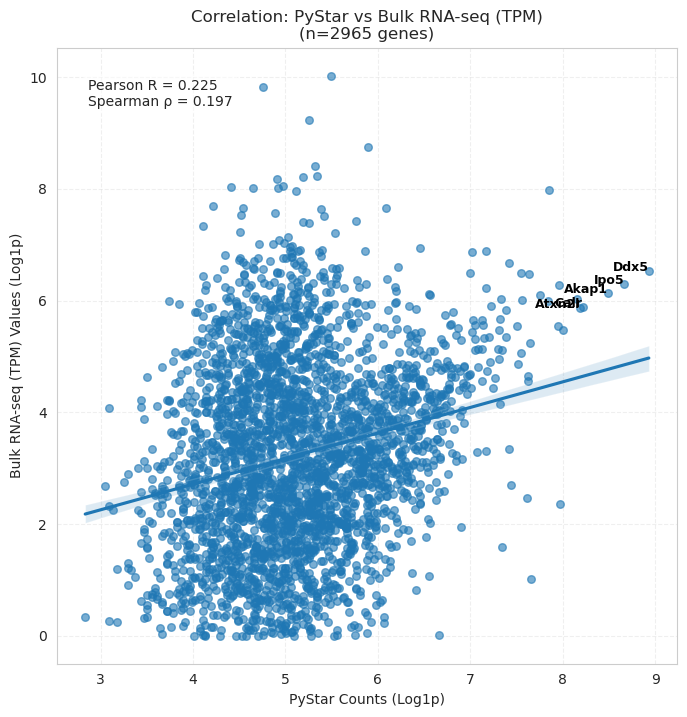


[========== Comparison: PyStar vs Matlab Pseudobulk (CPM) ==========]
 Common Genes: 3016
 Pearson R : 0.9201
 Spearman R: 0.9089


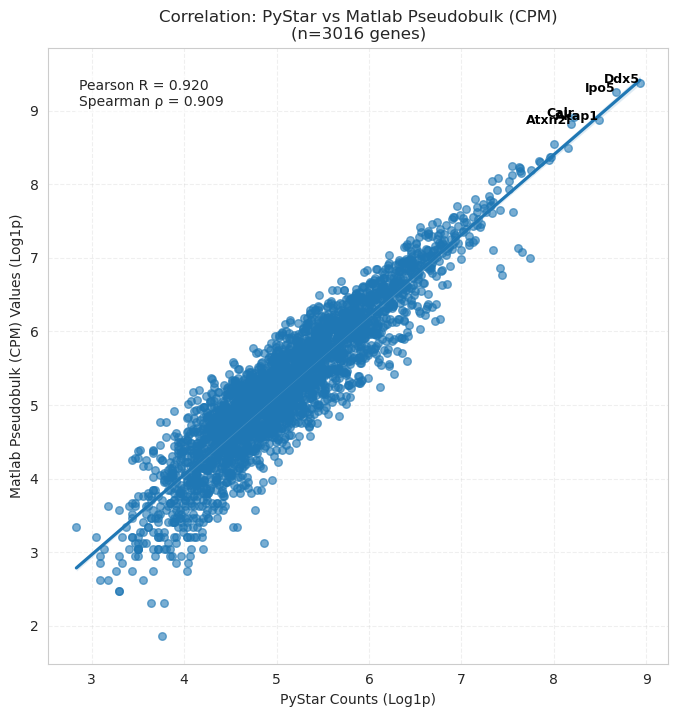

In [27]:
# 引入验证器
from pystar.visualization import ExpressionValidator

# 1. 初始化
# 指向你刚刚生成的结果
decoded_csv = "/media/zenglab/data/zhui/Leica_deconv_test/output_pystar/decoded/decoded_fov_1.csv"
validator = ExpressionValidator(decoded_csv)

# 2. 对比 RNA-seq TPM
# 注意：文件里的列名是 "Name" 和 "SRR453140"
tpm_file = "/media/zenglab/data/zhui/Leica_deconv_test/gene_tpm.tsv"
validator.compare_with_reference(
    ref_path=tpm_file,
    gene_col="Name",       # 参考文件的基因列名
    value_col="SRR453140", # 参考文件的数值列名
    label="Bulk RNA-seq (TPM)"
)

# 3. 对比 Pseudobulk CPM 即matlab 流程结果
# 注意：文件里的列名是 "gene_clean" 和 "CPM"
cpm_file = "/media/zenglab/data/zhui/Leica_deconv_test/pseudobulk_counts_cpm.noise0.tsv"
validator.compare_with_reference(
    ref_path=cpm_file,
    gene_col="gene_clean", # 参考文件的基因列名
    value_col="CPM",       # 参考文件的数值列名
    label="Matlab Pseudobulk (CPM)"
)

[==================== Loading Data ====================]
 MATLAB (Reference): 588002 spots loaded.
 First 3 Coords (Adjusted 0-based z,y,x):
[[  0 336  18]
 [  2 104  21]
 [  0 194  20]]
 PyStar (Prediction): 765950 mapped spots (Background removed).
 First 3 Coords:
[[   0.    23.   321. ]
 [   0.    23.   368.5]
 [   0.    23.  1158. ]]

[==================== Running Benchmarks ====================]

Metric 1: Spatial Recall (Did we find the spot?)
 -> 455037 / 588002 (77.39%)
    (Threshold: 4.0 pixels)

Metric 2: Gene Identity Accuracy (If found, is it correct?)
 -> 82420 / 455037 (18.11%)

Metric 3: Total Pipeline Recall (Strict Match)
 -> 82420 / 588002 (14.02%)

Top 10 Gene Confusions (Matlab -> PyStar):
Ddx5_rbRNA -> Ddx5_ntRNA
Ipo5_rbRNA -> Ipo5_ntRNA
Ddx5_ntRNA -> Ddx5_rbRNA
Ipo5_ntRNA -> Ipo5_rbRNA
Akap1_ntRNA -> Akap1_rbRNA
Calr_ntRNA -> Calr_rbRNA
Akap1_rbRNA -> Akap1_ntRNA
Canx_ntRNA -> Canx_rbRNA
Hk1_rbRNA -> Hk1_ntRNA
Calr_rbRNA -> Calr_ntRNA


/tmp/ipykernel_3328209/3295984563.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_confusions.index, x=top_confusions.values, ax=axes[1], palette="viridis")


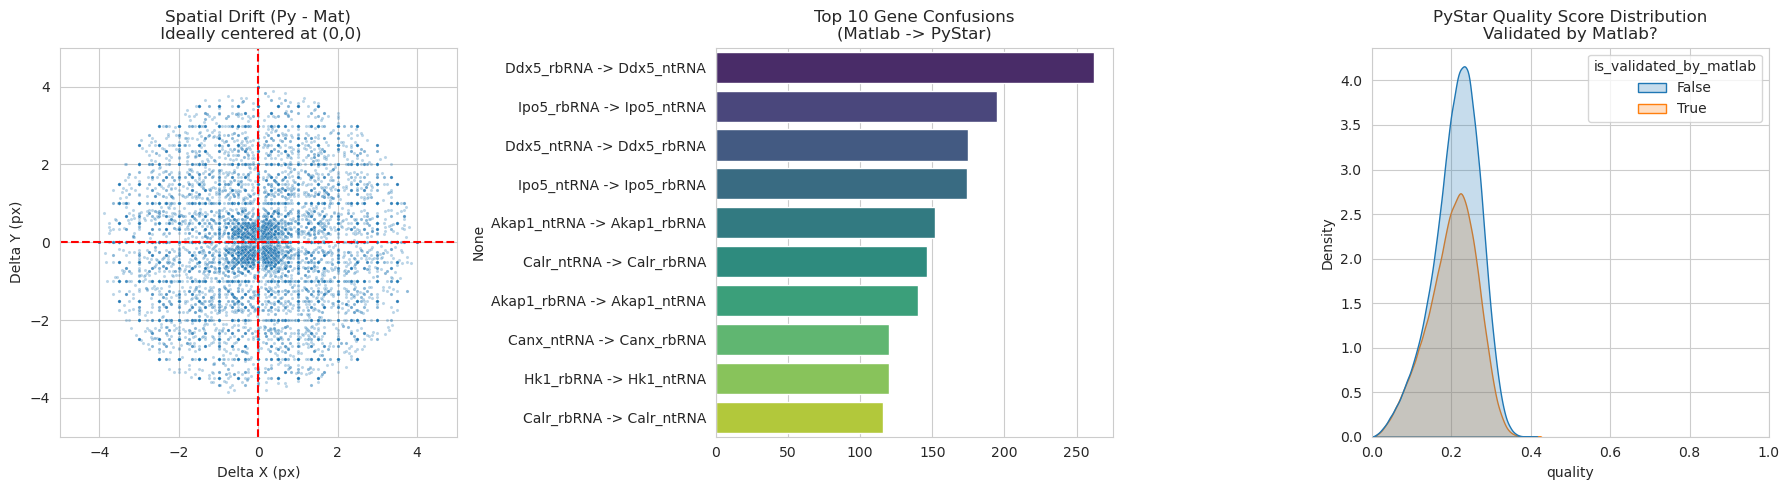


[==================== The Top Gene Verdict ====================]
MATLAB Top 5 Genes:
Ddx5_ntRNA      4144
Ipo5_ntRNA      3477
Ipo5_rbRNA      3112
Ddx5_rbRNA      2787
Atxn2l_ntRNA    2558
Name: gene, dtype: int64

PyStar Top 5 Genes:
Cfap91_ntRNA    5276
Trp63_ntRNA     4532
Cfap54_ntRNA    4342
Ddx5_ntRNA      3857
Axl_ntRNA       3623
Name: gene, dtype: int64


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.spatial import cKDTree
from pathlib import Path

# ================= Configuration =================
# 路径配置
path_matlab = "/media/zenglab/data/zhui/Leica_deconv_test/Leica_test_goodPoints_max3d.csv"
path_pystar = "/media/zenglab/data/zhui/Leica_deconv_test/output_pystar/decoded/decoded_fov_1.csv"

# 匹配容差 (像素)
# 允许有一定的漂移，因为算法不同 (Center of Mass vs Gaussian Peak)
DISTANCE_THRESHOLD = 4.0 

# ================= 1. Data Loading =================
print(f"[{'='*20} Loading Data {'='*20}]")

# Load MATLAB (Ground Truth)
try:
    df_mat = pd.read_csv(path_matlab)
    # MATLAB: x,y,z (1-based) -> z,y,x (0-based)
    # 重命名列以统一标准
    df_mat = df_mat.rename(columns={'Gene': 'gene'})
    
    # !!! CRITICAL FIX !!!
    # MATLAB is 1-based, Python is 0-based. Subtract 1.
    mat_coords = np.vstack([
        df_mat['z'] - 1, 
        df_mat['y'] - 1, 
        df_mat['x'] - 1
    ]).T
    
    print(f" MATLAB (Reference): {len(df_mat)} spots loaded.")
    print(f" First 3 Coords (Adjusted 0-based z,y,x):\n{mat_coords[:3]}")
    
except Exception as e:
    print(f"Error loading MATLAB file: {e}")
    raise

# Load PyStar (Prediction)
try:
    df_py = pd.read_csv(path_pystar)
    # PyStar: 包含 background，需要过滤
    df_py_mapped = df_py[df_py['gene'] != 'background'].copy()
    
    py_coords = df_py_mapped[['z', 'y', 'x']].values
    
    print(f" PyStar (Prediction): {len(df_py_mapped)} mapped spots (Background removed).")
    print(f" First 3 Coords:\n{py_coords[:3]}")
    
except Exception as e:
    print(f"Error loading PyStar file: {e}")
    raise

# ================= 2. Spatial Matching (KD-Tree) =================
print(f"\n[{'='*20} Running Benchmarks {'='*20}]")

if len(df_py_mapped) == 0:
    print("FATAL: PyStar found 0 mapped spots. Benchmark aborted.")
else:
    # Build Tree on PyStar spots (Look up table)
    tree = cKDTree(py_coords)

    # Query: For every MATLAB spot, find closest PyStar spot
    # k=1: closest neighbor
    dists, idxs = tree.query(mat_coords, k=1)

    # Filter matches within threshold
    is_spatial_match = dists <= DISTANCE_THRESHOLD
    
    # Extract data for matches
    mat_matched_indices = np.where(is_spatial_match)[0] # Mat indices that found a partner
    py_matched_indices = idxs[is_spatial_match]         # The partner Py indices

    # Create a Comparison DataFrame
    df_compare = pd.DataFrame({
        'dist': dists[is_spatial_match],
        'mat_gene': df_mat.iloc[mat_matched_indices]['gene'].values,
        'py_gene': df_py_mapped.iloc[py_matched_indices]['gene'].values,
        'py_barcode': df_py_mapped.iloc[py_matched_indices]['barcode'].values,
        'py_quality': df_py_mapped.iloc[py_matched_indices]['quality'].values
    })

    # Check Identity
    # 注意: 大小写敏感? 通常基因名首字母大写
    df_compare['gene_match'] = df_compare['mat_gene'] == df_compare['py_gene']

    # ================= 3. Metrics Calculation =================
    n_mat = len(df_mat)
    n_py = len(df_py_mapped)
    n_spatial_match = len(df_compare)
    n_gene_match = df_compare['gene_match'].sum()

    recall_spatial = n_spatial_match / n_mat
    recall_gene = n_gene_match / n_mat
    accuracy_gene = n_gene_match / n_spatial_match if n_spatial_match > 0 else 0

    print(f"\nMetric 1: Spatial Recall (Did we find the spot?)")
    print(f" -> {n_spatial_match} / {n_mat} ({recall_spatial:.2%})")
    print(f"    (Threshold: {DISTANCE_THRESHOLD} pixels)")

    print(f"\nMetric 2: Gene Identity Accuracy (If found, is it correct?)")
    print(f" -> {n_gene_match} / {n_spatial_match} ({accuracy_gene:.2%})")
    
    print(f"\nMetric 3: Total Pipeline Recall (Strict Match)")
    print(f" -> {n_gene_match} / {n_mat} ({recall_gene:.2%})")

    # ================= 4. Diagnosis Plots =================
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot A: Spatial Offset Scatter (How precise is the alignment?)
    # 画出偏移量的分布，看是否系统性偏移（比如所有点都向右偏了1像素）
    # Offset Vectors
    # Py coords - Mat coords
    offsets = py_coords[py_matched_indices] - mat_coords[mat_matched_indices] # (N, 3)
    # Take Y, X offsets
    sns.scatterplot(x=offsets[:, 2], y=offsets[:, 1], s=5, alpha=0.3, ax=axes[0])
    axes[0].set_title("Spatial Drift (Py - Mat)\n Ideally centered at (0,0)")
    axes[0].set_xlabel("Delta X (px)")
    axes[0].set_ylabel("Delta Y (px)")
    axes[0].axhline(0, color='red', ls='--')
    axes[0].axvline(0, color='red', ls='--')
    axes[0].set_xlim(-5, 5)
    axes[0].set_ylim(-5, 5)

    # Plot B: Who did we confuse? (Top 10 Mismatches)
    mismatches = df_compare[~df_compare['gene_match']]
    if len(mismatches) > 0:
        # Create a "Matlab Gene -> PyStar Gene" string
        confusion_pairs = mismatches['mat_gene'] + " -> " + mismatches['py_gene']
        top_confusions = confusion_pairs.value_counts().head(10)
        print("\nTop 10 Gene Confusions (Matlab -> PyStar):")
        for i in top_confusions.index:
            print(f"{i}")
        sns.barplot(y=top_confusions.index, x=top_confusions.values, ax=axes[1], palette="viridis")
        axes[1].set_title("Top 10 Gene Confusions\n(Matlab -> PyStar)")
    else:
        axes[1].text(0.5, 0.5, "Perfect Match!", ha='center')

    # Plot C: Quality of Matched vs Unmatched lines
    # PyStar 找到的那些点，如果跟 Matlab 对上了，是不是质量通常更高？
    df_py_mapped['is_validated_by_matlab'] = False
    df_py_mapped.iloc[py_matched_indices, df_py_mapped.columns.get_loc('is_validated_by_matlab')] = True
    
    sns.kdeplot(data=df_py_mapped, x='quality', hue='is_validated_by_matlab', fill=True, ax=axes[2])
    axes[2].set_title("PyStar Quality Score Distribution\nValidated by Matlab?")
    axes[2].set_xlim(0, 1.0)
    
    plt.tight_layout()
    plt.show()

    # ================= 5. The Trem2/Sst Verdict =================
    print(f"\n[{'='*20} The Top Gene Verdict {'='*20}]")
    mat_top = df_mat['gene'].value_counts().head(5)
    py_top = df_py_mapped['gene'].value_counts().head(5)
    
    print("MATLAB Top 5 Genes:")
    print(mat_top)
    print("\nPyStar Top 5 Genes:")
    print(py_top)

[========== Spot Inspector ==========]
 Gene: Ddx5_ntRNA
 Ranking: 2222/4952
 Barcode: 12111211220
 Quality: 0.0237
 Position (R1): Z=7.0, Y=1215.5, X=779.0


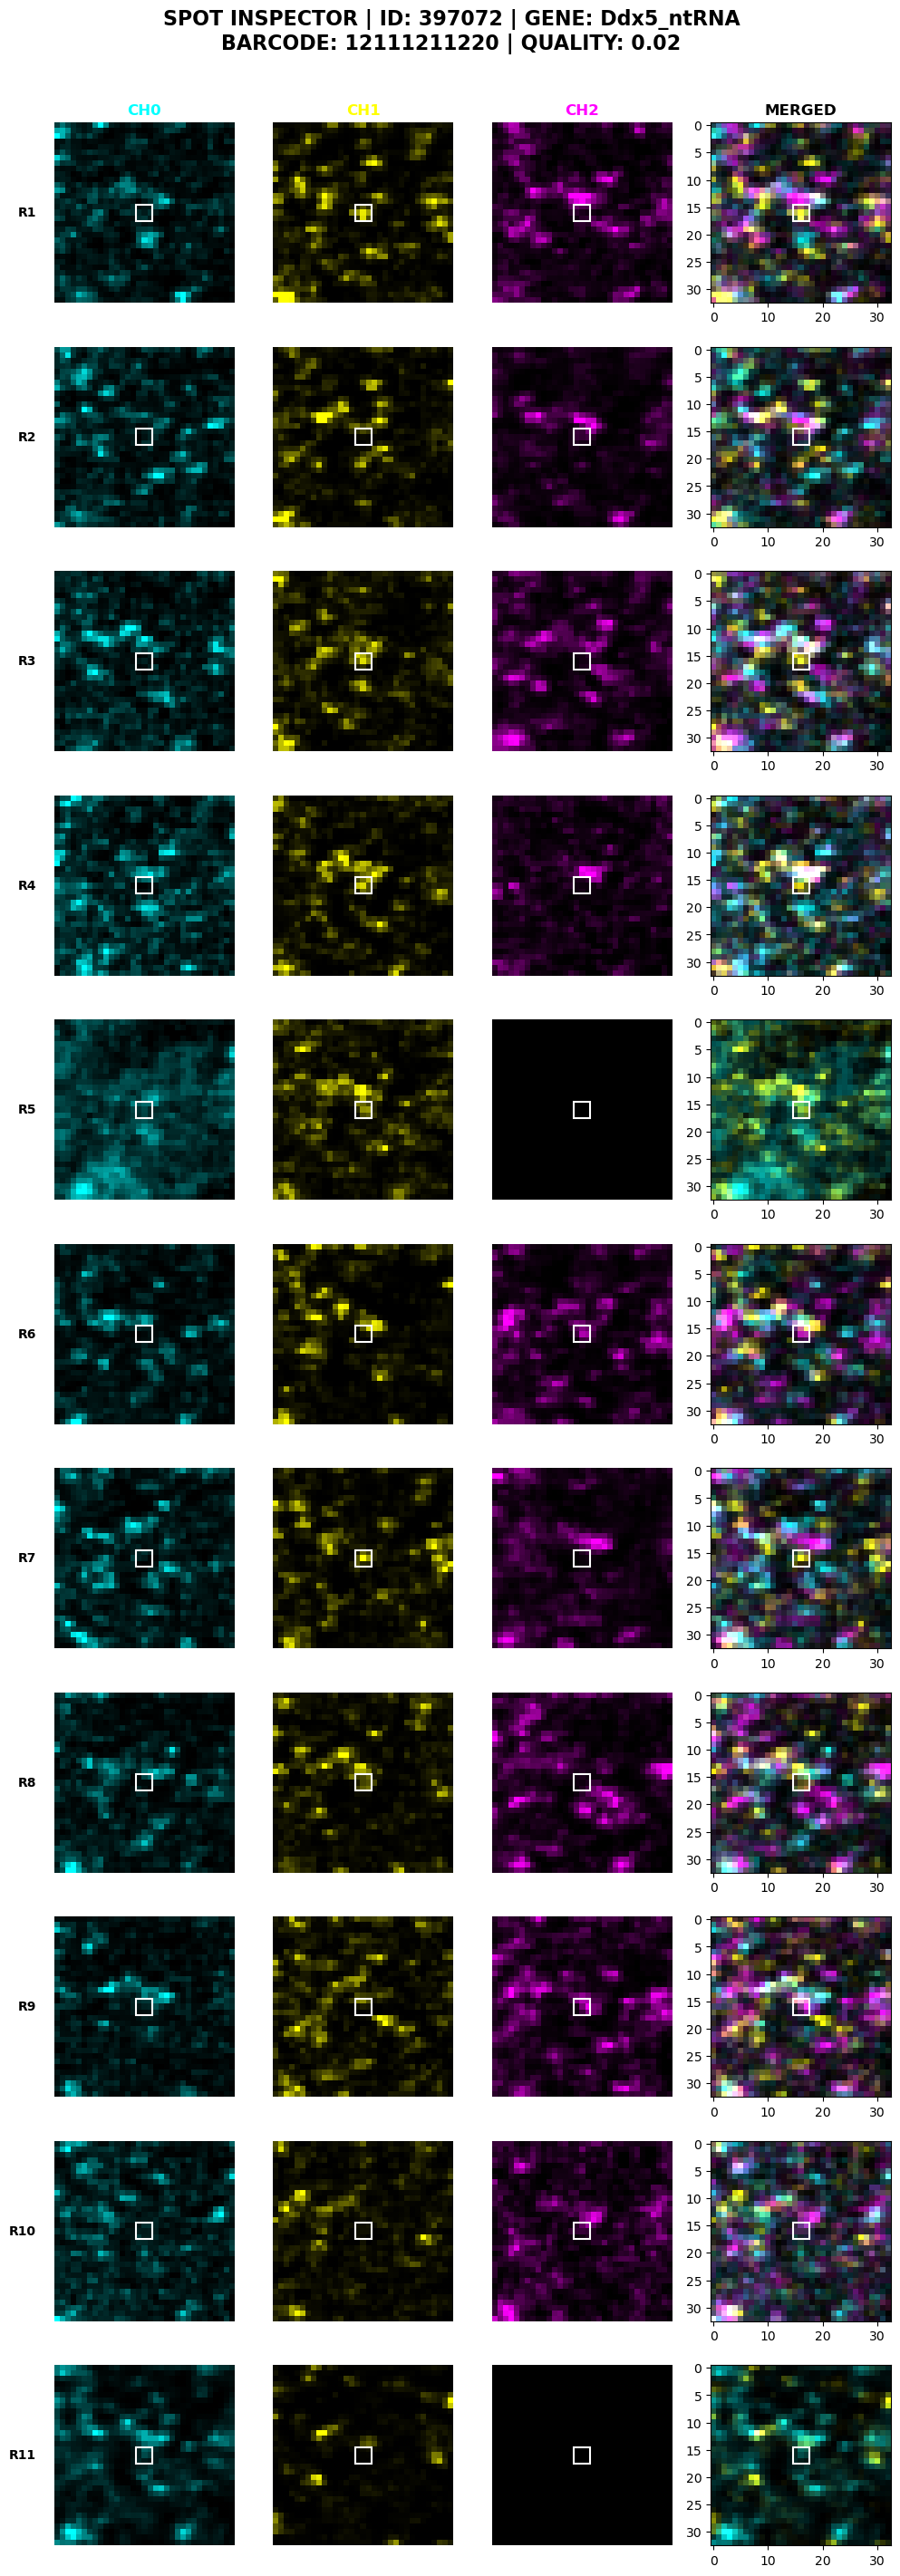

In [16]:

inspector = SpotInspector(cfg, FOV_ID)

gene = "Ddx5_ntRNA" 
idx = 2222

inspector.view_gene(gene, idx)

Loading data...
Total Genes compared: 6032
              Matlab_Counts  PyStar_Counts  Log_Matlab  Log_PyStar
Ddx5_ntRNA             4144           4952    3.617525    3.694868
Ipo5_ntRNA             3477           3556    3.541330    3.551084
Ipo5_rbRNA             3112           2255    3.493179    3.353339
Ddx5_rbRNA             2787           2611    3.445293    3.416973
Atxn2l_ntRNA           2558           2525    3.408070    3.402433

Pearson R (Log-Space): 0.8994
Slope: 0.7620 (Ideal = 1.0)


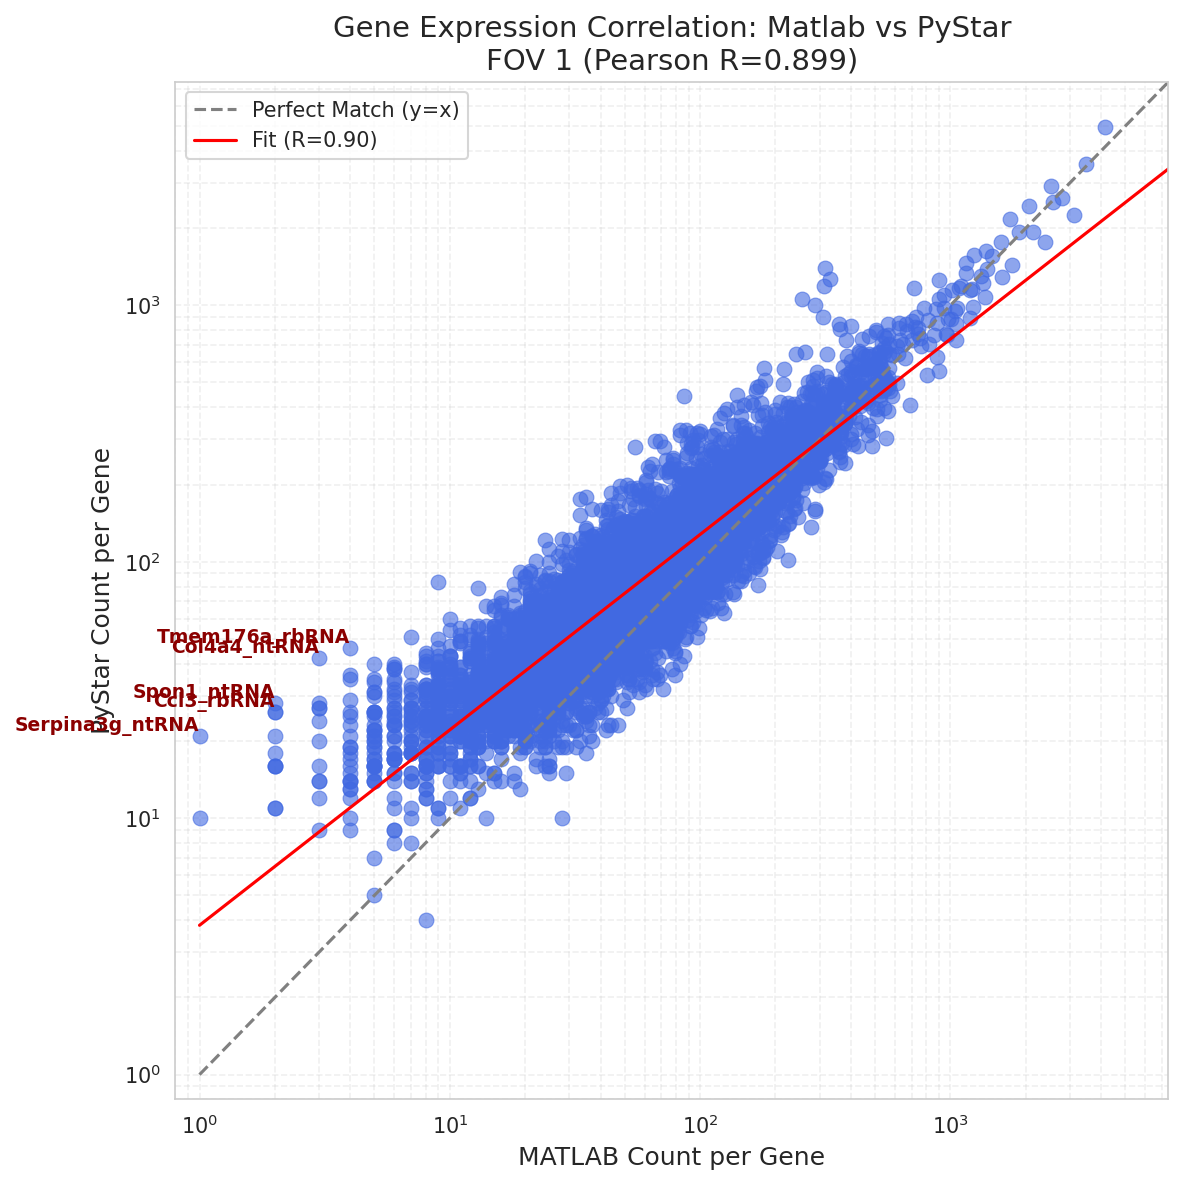


--- Outlier Report ---
No genes severely under-counted.

Genes severely OVER-counted by PyStar (Py > 10x of Mat):
                 Matlab_Counts  PyStar_Counts
Tmem176a_rbRNA               4             46
Col4a4_ntRNA                 3             42
Agt_ntRNA                    2             26
Ccl3_rbRNA                   2             26
Spon1_ntRNA                  2             28
Serpina3g_rbRNA              2             21
Serpina3g_ntRNA              1             21


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from pathlib import Path

print("Loading data...")
try:
    # Load
    df_mat = pd.read_csv(path_matlab)
    df_py = pd.read_csv(path_pystar)
    
    # Clean PyStar (Remove background)
    df_py = df_py[df_py['gene'] != 'background']
    
    # Standardize Column Names
    # Matlab uses "Gene", PyStar uses "gene"
    if 'Gene' in df_mat.columns: df_mat.rename(columns={'Gene': 'gene'}, inplace=True)
    
    # --- Count Genes ---
    counts_mat = df_mat['gene'].value_counts().rename("Matlab_Counts")
    counts_py = df_py['gene'].value_counts().rename("PyStar_Counts")
    
    # Merge (Outer Join to keep genes found in one but not the other)
    df_corr = pd.concat([counts_mat, counts_py], axis=1).fillna(0)
    
    # Log Transformation (Log10(Count + 1))
    # 基因表达量通常跨越几个数量级，不取 Log 全部挤在左下角看不清
    df_corr['Log_Matlab'] = np.log10(df_corr['Matlab_Counts'] + 1)
    df_corr['Log_PyStar'] = np.log10(df_corr['PyStar_Counts'] + 1)
    
    print(f"Total Genes compared: {len(df_corr)}")
    print(df_corr.head())

except Exception as e:
    print(f"Data processing failed: {e}")
    raise

# ================= 2. Calculation =================
# Pearson Correlation (on Log data is usually more robust for plots)
r_log, p_val = stats.pearsonr(df_corr['Log_Matlab'], df_corr['Log_PyStar'])
# Linear Regression slope
slope, intercept, _, _, _ = stats.linregress(df_corr['Log_Matlab'], df_corr['Log_PyStar'])

print(f"\nPearson R (Log-Space): {r_log:.4f}")
print(f"Slope: {slope:.4f} (Ideal = 1.0)")

# ================= 3. Visualization =================
plt.figure(figsize=(8, 8), dpi=150)
sns.set_style("whitegrid")

# Main Scatter
ax = sns.scatterplot(
    data=df_corr, 
    x='Matlab_Counts', 
    y='PyStar_Counts', 
    alpha=0.6, 
    edgecolor=None,
    s=50,
    color='royalblue'
)

# Log Scale Axes
ax.set_xscale('log')
ax.set_yscale('log')

# Limits (Make it square)
limit = max(df_corr['Matlab_Counts'].max(), df_corr['PyStar_Counts'].max()) * 1.5
ax.set_xlim(0.8, limit) # log scale can't go to 0, start at ~0.8 to show count=1
ax.set_ylim(0.8, limit)

# Identity Line (Perfect Match y=x)
ax.plot([1, limit], [1, limit], color='gray', linestyle='--', linewidth=1.5, label='Perfect Match (y=x)')

# Regression Line
x_vals = np.linspace(1, limit, 100)
# Convert log regression back to linear space for plotting
# y = 10^(intercept + slope * log10(x))
y_vals = 10**(intercept + slope * np.log10(x_vals))
ax.plot(x_vals, y_vals, color='red', linestyle='-', linewidth=1.5, label=f'Fit (R={r_log:.2f})')

# Annotate Specific Genes (Outliers)
# 找出偏差最大的前 5 个基因 (Residuals)
df_corr['Residual'] = np.abs(df_corr['Log_PyStar'] - df_corr['Log_Matlab'])
top_mismatches = df_corr.sort_values('Residual', ascending=False).head(5)

texts = []
for gene, row in top_mismatches.iterrows():
    # Only label if counts are substantial (e.g., > 10) to avoid noise
    if row['Matlab_Counts'] > 10 or row['PyStar_Counts'] > 10:
        plt.text(
            row['Matlab_Counts'], 
            row['PyStar_Counts'], 
            gene, 
            fontsize=9, 
            color='darkred',
            fontweight='bold',
            ha='right', va='bottom'
        )

# Titles and Labels
plt.title(f"Gene Expression Correlation: Matlab vs PyStar\nFOV 1 (Pearson R={r_log:.3f})", fontsize=14)
plt.xlabel("MATLAB Count per Gene", fontsize=12)
plt.ylabel("PyStar Count per Gene", fontsize=12)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.3)

plt.tight_layout()
plt.show()

# ================= 4. Text Report =================
# Missing in PyStar? (Recall issue)
missing_in_py = df_corr[df_corr['PyStar_Counts'] < 0.1 * df_corr['Matlab_Counts']]
# Missing in Matlab? (Specificity issue or better finding)
extra_in_py = df_corr[df_corr['PyStar_Counts'] > 10 * df_corr['Matlab_Counts']]

print("\n--- Outlier Report ---")
if not missing_in_py.empty:
    print(f"Genes severely UNDER-counted by PyStar (Py < 10% of Mat):")
    print(missing_in_py[['Matlab_Counts', 'PyStar_Counts']].head(10))
else:
    print("No genes severely under-counted.")

if not extra_in_py.empty:
    print(f"\nGenes severely OVER-counted by PyStar (Py > 10x of Mat):")
    print(extra_in_py[['Matlab_Counts', 'PyStar_Counts']].head(10))
else:
    print("\nNo genes severely over-counted.")